<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 20px; background-color: #f9f9f9;">

# 🧠 Introduction to Reinforcement Learning – Final Project  
## Optimal Policy Learning in Dynamic Environments using Deep Reinforcement Learning

---

### 📌 Introduction

Reinforcement Learning (RL) is a computational framework in which an agent learns to make sequential decisions by interacting with an environment.  
The goal is to **maximize cumulative reward over time**, balancing exploration of new strategies with exploitation of known ones.  
This project applies core concepts from the course to a practical simulation-based task, building and training an agent to learn effective behavior in a dynamic and stochastic environment.

---

### 🎯 Project Objective

To investigate how an intelligent agent can learn optimal decision-making strategies using Deep Reinforcement Learning techniques.  
We simulate a custom hospital environment, implement and train RL agents, compare them to non-learning baselines, and evaluate their ability to optimize scheduling decisions under uncertainty and time constraints.

---

### 🗂 Table of Contents

1. [Simulated Environment Overview](#simulated-environment-overview)  
   - Environment structure, surgery generation, and statistical analysis
2. [Environment Wrappers: RandomPatientReset & FlattenObservation](#environment-wrappers-randompatientreset--flattenobservation)  
   - Preprocessing and observation flattening
3. [Baseline Evaluation of RL Models](#baseline-evaluation-of-rl-models)  
   - Performance of DQN, PPO, and A2C using default parameters
4. [Model Training, Tuning, and Non-Learning Baselines](#model-training-tuning-and-non-learning-baselines)  
   - Hyperparameter search, performance comparison  
   - Random & Heuristic baselines for benchmarking
5. [Visual Comparison: Training vs Evaluation](#visual-comparison-training-vs-evaluation)  
   - Generalization curves and stability analysis
6. [Conclusions & Final Recommendation](#conclusions--final-recommendation)
7. [🎥 Agent Simulation: Watch the Best Model in Action](#agent-simulation-watch-the-best-model-in-action)

</div>


## 🔧 Environment Setup and Preprocessing

In this section, we define and prepare the custom reinforcement learning environment used throughout the project.  
We import essential libraries, generate a simulated list of surgeries, and construct the operating room environment.  
To support the RL agent, we apply two wrappers:
- One ensures randomized patient scenarios on each reset.
- The other flattens the environment’s observations into a fixed-size vector suitable for standard RL algorithms.


In [1]:
# Cell 1: Imports
import gymnasium as gym
from gymnasium import ObservationWrapper, spaces
import numpy as np
import matplotlib.pyplot as plt
import shimmy
from env import OperatingRoomEnv, generate_surgeries
import pandas as pd
import random
import torch
from stable_baselines3 import DQN, PPO, A2C
import seaborn as sns

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## 🏥 Simulated Environment Overview: Surgical Scheduling

To evaluate different reinforcement learning strategies, we designed a simulated hospital environment that models a single day of operating room scheduling.

Each **episode** simulates a single surgical day with:
- **15 patients** arriving over a day length of 480 minutes (8 hours).
- Each patient has:
  - Arrival time (0–480)
  - Surgery duration (30–70 minutes)
  - Urgency level (1 = elective, 2 = semi-urgent, 3 = urgent)

---

### 📈 Statistical Insights (Single Episode Example)

```python
Total planned surgery duration: 676 minutes  
Number of urgent patients: 7  
Earliest arrival: 20, latest: 400  
Mean duration: 45.1 minutes  
Standard deviation: 10.6 minutes


In [2]:
surgeries = generate_surgeries(num_surgeries=15, min_duration=30, max_duration=70, day_length=480)

durations = [s['duration'] for s in surgeries]
arrival_times = [s['arrival_time'] for s in surgeries]
urgencies = [s['urgency'] for s in surgeries]

print(f"Total planned surgery duration: {sum(durations)} minutes")
print(f"Number of urgent patients: {sum(1 for u in urgencies if u==3)}")
print(f"Earliest arrival: {min(arrival_times)}, latest: {max(arrival_times)}")
print(f"Mean duration: {np.mean(durations):.1f}, std: {np.std(durations):.1f}")


Total planned surgery duration: 822 minutes
Number of urgent patients: 3
Earliest arrival: 1, latest: 394
Mean duration: 54.8, std: 10.6


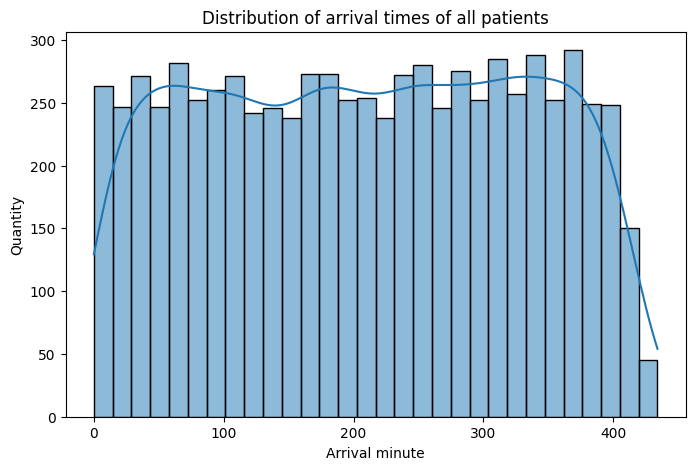

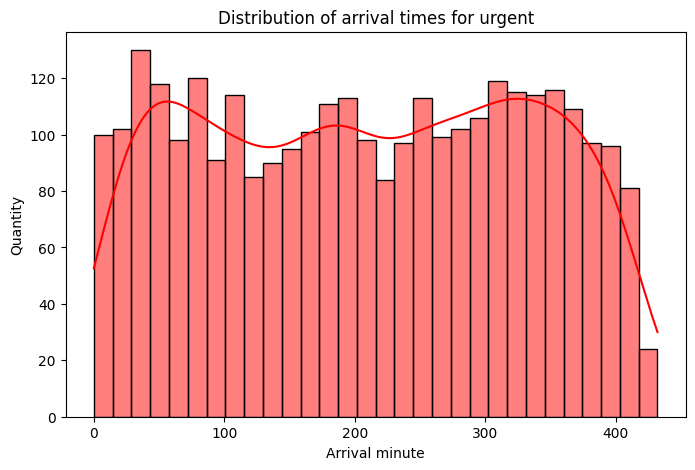

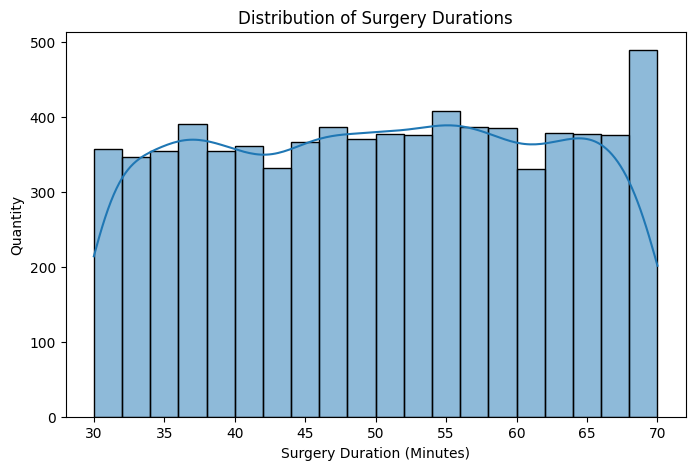

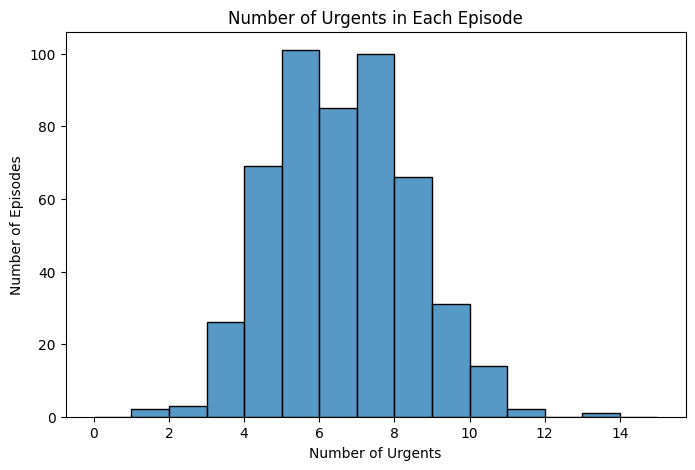

In [3]:
all_surgeries = []
for _ in range(500):
    surgeries = generate_surgeries(num_surgeries=15, min_duration=30, max_duration=70, day_length=480)
    for s in surgeries:
        all_surgeries.append({
            'duration': s['duration'],
            'arrival_time': s['arrival_time'],
            'urgency': s['urgency']
        })

df = pd.DataFrame(all_surgeries)

# התפלגות זמני הגעה
plt.figure(figsize=(8,5))
sns.histplot(df['arrival_time'], bins=30, kde=True)
plt.title('Distribution of arrival times of all patients')
plt.xlabel('Arrival minute')
plt.ylabel('Quantity')
plt.show()

# התפלגות זמני הגעה של דחופים בלבד
plt.figure(figsize=(8,5))
sns.histplot(df[df['urgency'] == 3]['arrival_time'], bins=30, kde=True, color='red')
plt.title('Distribution of arrival times for urgent')
plt.xlabel('Arrival minute')
plt.ylabel('Quantity')
plt.show()

# התפלגות משך הניתוחים
plt.figure(figsize=(8,5))
sns.histplot(df['duration'], bins=20, kde=True)
plt.title('Distribution of Surgery Durations')
plt.xlabel('Surgery Duration (Minutes)')
plt.ylabel('Quantity')
plt.show()

# כמה דחופים בכל אפיזודה?
urgent_counts = []
for _ in range(500):
    surgeries = generate_surgeries(num_surgeries=15, min_duration=30, max_duration=70, day_length=480)
    urgent_counts.append(sum(1 for s in surgeries if s['urgency'] == 3))

plt.figure(figsize=(8,5))
sns.histplot(urgent_counts, bins=range(0, 16), kde=False)
plt.title('Number of Urgents in Each Episode')
plt.xlabel('Number of Urgents')
plt.ylabel('Number of Episodes')
plt.show()


---
### 🧩 RandomPatientResetWrapper

This wrapper modifies the environment’s `reset()` method to inject a randomized patient list at the beginning of each episode.  
By setting `random_patients=True`, we simulate different daily schedules, increasing variability and supporting generalization during training.

**Purpose:**  
To ensure that the agent does not overfit to a fixed set of surgeries, encouraging robust decision-making under uncertainty.


In [4]:
class RandomPatientResetWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        kwargs['random_patients'] = True
        return self.env.reset(**kwargs)

In [5]:
# Cell 3: יצירת רשימת ניתוחים והסביבה
surgeries = generate_surgeries(num_surgeries=15, day_length=480)
env = OperatingRoomEnv(num_rooms=3, surgeries=surgeries, day_length=480, max_patients_in_obs=8)


### 🧩 FlattenObservationWrapper

This wrapper transforms the structured observation dictionary into a flat NumPy array, making it compatible with standard RL agents that expect vector inputs.  
It extracts and concatenates the following fields:
- Operating room status
- Current time
- Number of patients waiting
- Waiting times and urgency levels

**Purpose:**  
To convert complex observations into a uniform, numerical format suitable for deep RL models such as DQN.


In [6]:
# Cell 4: פונקציית flatten ו־wrapper לסביבה
def flatten_obs(obs):
    return np.concatenate([
        obs['rooms'].flatten(),
        [obs['time']],
        [obs['num_waiting']],
        obs['waiting_times'].flatten(),
        obs['urgencies'].flatten()
    ])


class FlattenObservationWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        n = (
            self.observation_space['rooms'].shape[0]
            + 1  # time
            + 1  # num_waiting
            + self.observation_space['waiting_times'].shape[0]
            + self.observation_space['urgencies'].shape[0]
        )
        self.observation_space = spaces.Box(low=0, high=1000, shape=(n,), dtype=np.float32)

    def observation(self, obs):
        return flatten_obs(obs)
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        #print("reset wrapper:", type(obs), type(info))
        return self.observation(obs), info  # מחזיר רק obs, בלי info!
        
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        #print("step wrapper:", type(info), info)
        return self.observation(obs), reward, terminated, truncated, info


env = RandomPatientResetWrapper(env)

# עטיפת הסביבה :
env = FlattenObservationWrapper(env)


In [7]:
env.reset()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), {})

In [8]:
obs, info= env.reset()
print(obs.shape)


(21,)


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## 📊 Baseline Evaluation of RL Models (DQN, PPO, A2C)

In this experiment, we compared the default performance of **three reinforcement learning models** on a fixed set of surgeries:

- **Models**: `DQN`, `PPO`, `A2C`
- **Training Steps**: 48,000 per model (≈ 100 episodes)
- **Seeds**: 4 consistent seeds – `[0, 42, 100, 999]`
- **Environment Setup**: Identical for all models (same patient list, observation wrapper, etc.)

Each model was evaluated using the **mean and standard deviation of total rewards** per episode.

---

### 📈 Summary Results

| Model | Avg. Mean Reward | Avg. Std of Mean | Avg. Std Reward |
|-------|------------------|------------------|------------------|
| **A2C** | **460.58**         | 695.98           | 644.65           |
| **PPO** | -1072.13          | 1249.19          | 1115.03          |
| **DQN** | -2400.97          | 766.64           | 1709.25          |

#### Mean reward by seed:
- **DQN**: -3239.41, -2644.70, -1404.22, -2315.53  
- **PPO**: -2904.67, -442.00, -152.12, -789.72  
- **A2C**: 888.17, 998.12, 485.78, **-529.75**

---

### 🧠 Key Observations

- ✅ **A2C** showed the **best average performance**, with three out of four seeds yielding positive results.
- ⚠️ However, **A2C also exhibited instability**, with a negative outlier at seed 999.
- 🚀 **PPO** showed **impressive robustness** for seeds 42, 100, and 999, but suffered a major failure on seed 0.
- ❌ **DQN** performed poorly and inconsistently across all seeds, even with relatively lower variance on some.

---

### 🏆 Preliminary Conclusion

> **A2C emerges as the most promising candidate** for further tuning, due to its high average reward and potential stability after hyperparameter optimization.

**PPO** is a close second, especially if the instability on seed 0 can be mitigated.

**DQN** is likely not a good fit for this problem under current conditions and will not be prioritized for tuning.

In [22]:
import warnings
warnings.filterwarnings("ignore")

SEEDS = [0, 42, 100, 999]
N_EVAL_EPISODES = 20  # מספיק לסטטיסטיקה בסיסית ומהירה
MODELS = {
    'DQN': DQN,
    'PPO': PPO,
    'A2C': A2C}


In [23]:
def set_seed_everywhere(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


In [24]:
def run_model_baseline(model_name, model_class, env, seeds=SEEDS, n_eval=N_EVAL_EPISODES):
    print(f"\n===== {model_name} | Baseline Params | Starting Tests =====")
    results = []
    for seed in seeds:
        set_seed_everywhere(seed)
        # איפוס סביבה
        surgeries = generate_surgeries(num_surgeries=15, seed=seed)
        env_instance = OperatingRoomEnv(num_rooms=3, surgeries=surgeries, day_length=480, max_patients_in_obs=8)
        env_instance = FlattenObservationWrapper(RandomPatientResetWrapper(env_instance))
        # יצירת מודל בפרמטרי ברירת מחדל
        model = model_class("MlpPolicy", env_instance, verbose=0, seed=seed)
        model.learn(total_timesteps=48_000)
        
        # הערכה
        rewards = []
        for ep in range(n_eval):
            # שינוי SEED כדי להימנע מניצול יתר
            surgeries = generate_surgeries(num_surgeries=15, seed=seed + ep + 1000)
            eval_env = OperatingRoomEnv(num_rooms=3, surgeries=surgeries, day_length=480, max_patients_in_obs=8)
            eval_env = FlattenObservationWrapper(RandomPatientResetWrapper(eval_env))
            obs, info = eval_env.reset()
            done = False
            total_reward = 0
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
                total_reward += reward
            rewards.append(total_reward)
        print(f"Seed {seed}: mean={np.mean(rewards):.2f}, std={np.std(rewards):.2f}")
        results.append({
            "model": model_name,
            "seed": seed,
            "mean_reward": np.mean(rewards),
            "std_reward": np.std(rewards)
        })
    return pd.DataFrame(results)


In [25]:
all_dfs = []
for model_name, model_class in MODELS.items():
    # הכנס סביבה כללית, או צור fresh env בפונקציה
    df = run_model_baseline(model_name, model_class, env=None)
    all_dfs.append(df)
summary_df = pd.concat(all_dfs, ignore_index=True)



===== DQN | Baseline Params | Starting Tests =====
Seed 0: mean=-3239.41, std=2419.93
Seed 42: mean=-2644.70, std=2308.18
Seed 100: mean=-1404.22, std=891.36
Seed 999: mean=-2315.53, std=1217.53

===== PPO | Baseline Params | Starting Tests =====
Seed 0: mean=-2904.67, std=2310.88
Seed 42: mean=-442.00, std=780.32
Seed 100: mean=-152.12, std=591.18
Seed 999: mean=-789.72, std=777.73

===== A2C | Baseline Params | Starting Tests =====
Seed 0: mean=888.17, std=268.78
Seed 42: mean=998.12, std=170.74
Seed 100: mean=485.78, std=724.86
Seed 999: mean=-529.75, std=1414.21


---
```python
===== DQN | Baseline Params | Starting Tests =====
Seed 0: mean=-3239.41, std=2419.93
Seed 42: mean=-2644.70, std=2308.18
Seed 100: mean=-1404.22, std=891.36
Seed 999: mean=-2315.53, std=1217.53

===== PPO | Baseline Params | Starting Tests =====
Seed 0: mean=-2904.67, std=2310.88
Seed 42: mean=-442.00, std=780.32
Seed 100: mean=-152.12, std=591.18
Seed 999: mean=-789.72, std=777.73

===== A2C | Baseline Params | Starting Tests =====
Seed 0: mean=888.17, std=268.78
Seed 42: mean=998.12, std=170.74
Seed 100: mean=485.78, std=724.86
Seed 999: mean=-529.75, std=1414.21
```
---


=== Summary by Model ===


,avg_mean_reward,std_mean_reward,avg_std_reward,runs
model,,,,
A2C,460.578750,695.982237,644.647789,4
PPO,-1072.126875,1249.192880,1115.027235,4
DQN,-2400.966875,766.636669,1709.250922,4


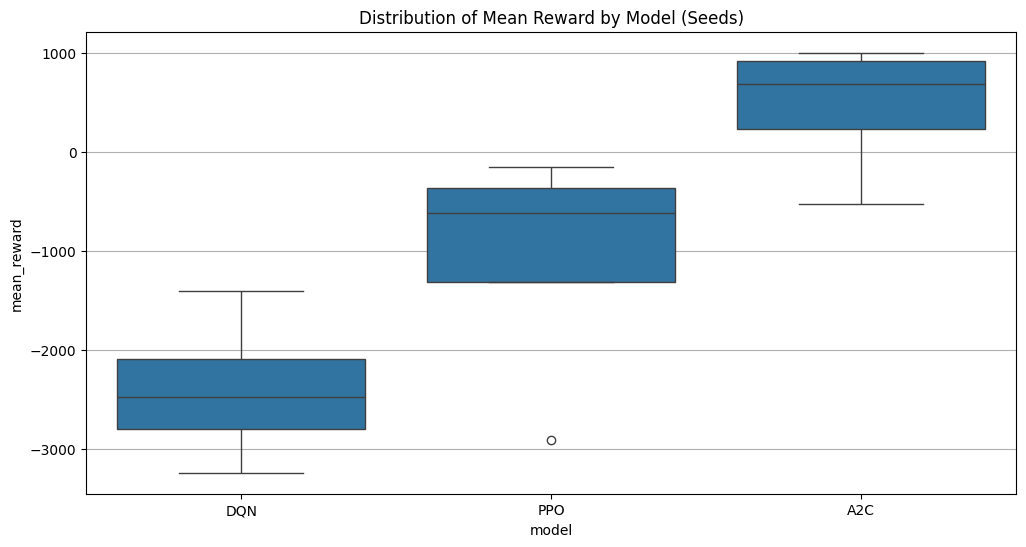

In [26]:
# טבלת סיכום סטטיסטי
print("\n=== Summary by Model ===")
display(summary_df.groupby("model").agg(
    avg_mean_reward=("mean_reward", "mean"),
    std_mean_reward=("mean_reward", "std"),
    avg_std_reward=("std_reward", "mean"),
    runs=("mean_reward", "count")
).sort_values("avg_mean_reward", ascending=False))

# הצגת התוצאות
import seaborn as sns
plt.figure(figsize=(12,6))
sns.boxplot(data=summary_df, x="model", y="mean_reward")
plt.title("Distribution of Mean Reward by Model (Seeds)")
plt.grid(axis="y")
plt.show()


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

# Grid Search DQN 

```python

import itertools
import time
from tqdm import tqdm

param_grid = {
    'learning_rate': [0.0001, 0.0002],
    'batch_size': [32, 64],
    'buffer_size': [30000, 40000],
    'gamma': [0.95, 0.99],
    'exploration_fraction': [0.1, 0.2],
    'exploration_final_eps': [0.05, 0.1],
    'net_arch': [[64, 64], [128, 128], [128, 256]],  
}

combos = list(itertools.product(*param_grid.values()))
print(f"Total {len(combos)} independent runs")

results = []

for idx, params in enumerate(tqdm(combos, desc="Grid Search Progress")):
    start = time.time()
    lr, bs, buf, gamma, expl_frac, expl_final, net_arch = params

    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=lr,
        batch_size=bs,
        buffer_size=buf,
        gamma=gamma,
        exploration_fraction=expl_frac,
        exploration_final_eps=expl_final,
        train_freq=4,
        target_update_interval=250,
        verbose=0,
        policy_kwargs=dict(net_arch=net_arch)
    )
    model.learn(total_timesteps=48_000)

    # הערכה קצרה – 20 אפיזודות
    eval_rewards = []
    for ep in range(20):
        obs, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        eval_rewards.append(total_reward)

    avg_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    min_reward = np.min(eval_rewards)
    max_reward = np.max(eval_rewards)
    median_reward = np.median(eval_rewards)
    duration = time.time() - start

    results.append({
        'learning_rate': lr,
        'batch_size': bs,
        'buffer_size': buf,
        'gamma': gamma,
        'exploration_fraction': expl_frac,
        'exploration_final_eps': expl_final,
        'net_arch': str(net_arch),    # שמור כמחרוזת לנוחות קריאה
        'avg_reward': avg_reward,
        'std_reward': std_reward,
        'min_reward': min_reward,
        'max_reward': max_reward,
        'median_reward': median_reward,
        'duration_sec': duration
    })

df_results_grid_DQN = pd.DataFrame(results)
df_results_grid_DQN = df_results_grid_DQN.sort_values('avg_reward', ascending=False).reset_index(drop=True)
df_results_grid_DQN.round(2)

In [9]:
# Load the DQN results file
df_g_res = pd.read_csv('df_results_grid_DQN_GRID_RES.csv')

# Basic statistics for avg_reward and std_reward
summary_g_dqn = df_g_res[['avg_reward', 'std_reward']].describe()

# Sort by avg_reward (descending) and show top 10 results
top_avg_dqn = df_g_res.sort_values(by='avg_reward', ascending=False).head(10)

# Calculate Sharpe-like ratio: avg_reward / std_reward (handle zero std_reward)
df_g_res['reward_sharpe'] = df_g_res['avg_reward'] / df_g_res['std_reward'].replace(0, float('nan'))
top_sharpe_dqn = df_g_res.sort_values(by='reward_sharpe', ascending=False).head(10)

In [11]:
top_sharpe_dqn

,learning_rate,batch_size,buffer_size,gamma,exploration_fraction,exploration_final_eps,net_arch,avg_reward,std_reward,min_reward,max_reward,median_reward,duration_sec,reward_sharpe
0,0.0001,64,30000,0.95,0.2,0.10,"[128, 256]",1071.0750,185.041104,709.35,1374.90,1118.400,64.221608,5.788309
2,0.0002,32,30000,0.99,0.1,0.10,"[128, 128]",903.6500,180.742194,597.05,1222.70,903.350,58.595834,4.999663
1,0.0002,64,40000,0.95,0.1,0.10,"[128, 256]",1006.5550,249.377310,393.80,1317.15,1068.275,72.728750,4.036273
8,0.0002,64,40000,0.95,0.2,0.10,"[128, 256]",749.7250,237.341647,229.30,1147.35,772.900,75.582021,3.158843
5,0.0002,32,40000,0.99,0.1,0.05,"[128, 256]",811.7600,274.276497,134.95,1233.15,851.900,70.130627,2.959641
3,0.0002,32,30000,0.95,0.2,0.10,"[128, 128]",862.4600,296.347908,73.90,1382.60,933.825,60.090015,2.910296
6,0.0002,64,30000,0.95,0.2,0.10,"[128, 256]",802.2675,398.473553,-46.50,1268.70,969.900,70.824864,2.013352
17,0.0002,64,30000,0.95,0.2,0.05,"[128, 128]",511.9800,266.965446,-132.65,995.40,508.300,65.437031,1.917776
7,0.0001,64,40000,0.99,0.1,0.05,"[128, 256]",758.4700,408.612932,-540.50,1254.20,888.000,70.411696,1.856207
25,0.0002,64,30000,0.99,0.2,0.10,"[128, 128]",352.3300,222.726958,-374.25,674.85,421.575,60.369329,1.581892


## 🏆 DQN – Best Hyperparameter Configuration and Analysis

From 192 grid search runs, the following DQN configurations outperformed the rest:

| learning_rate | batch_size | buffer_size | gamma | exploration_fraction | net_arch    | avg_reward | std_reward |
|---------------|------------|-------------|-------|---------------------|-------------|------------|------------|
| 0.0001        | 64         | 30000       | 0.95  | 0.2                 | [128, 256]  | 1071.08    | 185.04     |
| 0.0002        | 64         | 40000       | 0.95  | 0.1                 | [128, 256]  | 1006.56    | 249.38     |

**How to choose?**
- The top configuration (`avg_reward = 1071.08`) delivers the best average reward with a low standard deviation, suggesting both strong and reliable performance.
- The second-best configuration (`avg_reward = 1006.56`) is slightly behind in reward and has a higher standard deviation, making it less robust.

**Recommendation:**
- The first configuration is preferred, as it balances high average reward and stability, making it the optimal choice for most scenarios.


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# DQN

In [9]:
from stable_baselines3 import DQN

model = DQN(
    "MlpPolicy",           # רשת נוירונים קטנה (Multi-layer perceptron)
    env,                   # הסביבה שלך אחרי flatten
    policy_kwargs=dict(net_arch=[128, 256]),
    learning_rate=0.0002,    # קצב למידה (אפשר לשנות בהרצות שונות)
    buffer_size=40000,     # גודל מאגר החוויות
    learning_starts=500,   # כמה צעדים ראשונים "חוקרים" בלבד
    batch_size=64,
    exploration_fraction = 0.2,
    exploration_final_eps = 0.1,
    tau=1.0,
    gamma=0.95,            # מקדם היוון (discount factor)
    train_freq=4,
    target_update_interval=250,
    verbose=1,
)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 480      |
|    ep_rew_mean      | -76.5    |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1243     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1920     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.14     |
|    n_updates        | 354      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 478      |
|    ep_rew_mean      | 62.9     |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1130     |
|    time_elapsed     | 3        |
|    total_timesteps  | 3824     |
| train/              |          |
|    learning_rate    | 0.0002   |
|    loss             | 2.32     |
|    n_updates      

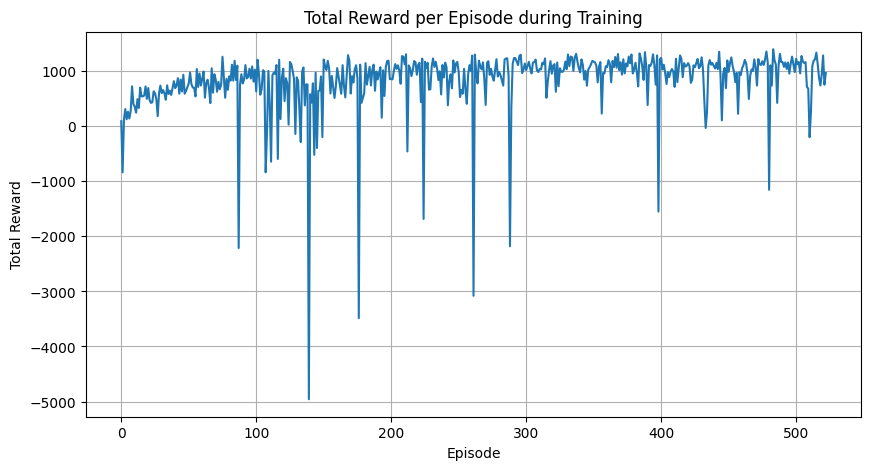

In [10]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.episode_rewards = []
        self.steps = []
        self.current_rewards = []

    def _on_step(self) -> bool:
        # לוקחים reward מהסביבה
        reward = self.locals.get('rewards', [None])[0]
        if reward is not None:
            self.current_rewards.append(reward)
        done = self.locals.get('dones', [False])[0]
        if done:
            self.episode_rewards.append(sum(self.current_rewards))
            self.current_rewards = []

        if self.num_timesteps % self.check_freq == 0:
            self.steps.append(self.num_timesteps)
        return True

# יצירת Callback
reward_logger = RewardLoggerCallback(check_freq=1000)

# איפוס הסוכן ואימון עם Callback
model.learn(total_timesteps=240_000, callback=reward_logger)

# ציור גרף Reward
plt.figure(figsize=(10,5))
plt.plot(reward_logger.episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Training')
plt.grid()
plt.show()


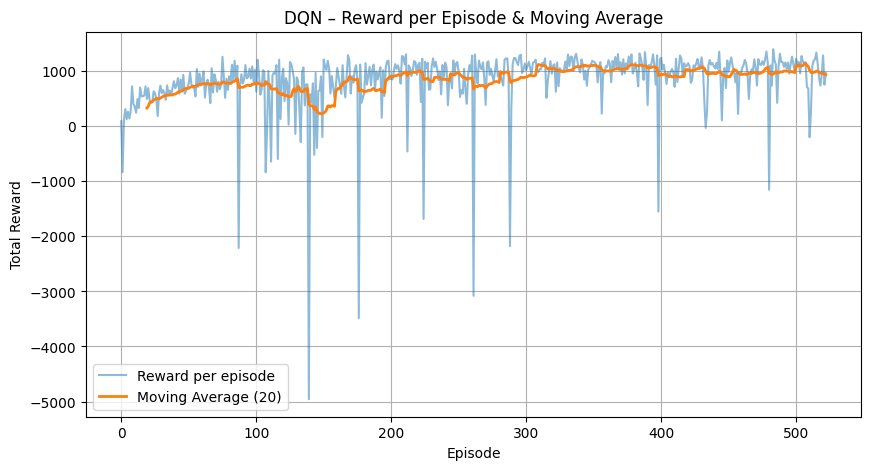

In [11]:
plt.figure(figsize=(10,5))
rewards = reward_logger.episode_rewards  # ודא שהמשתנה הנכון מוצמד למודל שרץ עכשיו
window = 20
ma = pd.Series(rewards).rolling(window).mean()
plt.plot(rewards, alpha=0.5, label="Reward per episode")
plt.plot(ma, linewidth=2, label=f"Moving Average ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("DQN – Reward per Episode & Moving Average")  # עדכן לשם המודל שרץ
plt.grid()
plt.show()


In [18]:
# Cell 7 : Save the trained model for future use
model.save("trained_dqn.zip")
print("Model saved!")

Model saved!


In [22]:
# Cell 8: Save the reward logger
import pickle
with open("rewards_logger_dqn.pkl", "wb") as f:
    pickle.dump(reward_logger.episode_rewards, f)
print("Episode rewards saved!")


Episode rewards saved!


In [23]:
# Cell 10: Load the trained agent (for evaluation)
from stable_baselines3 import DQN

model_dqn = DQN.load("trained_dqn.zip", env=env)
print("Loaded trained agent!")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded trained agent!


In [24]:
N_EVAL_EPISODES = 100

agent_rewards = []
agent_waiting_times = []
agent_urgent_served = []
agent_total_surgeries = []
agent_overtime_cases = []

def get_base_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

for ep in range(N_EVAL_EPISODES):
    obs, info = env.reset()
    done = False
    total_reward = 0
    waiting_times = []
    urgent_served = 0
    total_surgeries = 0
    overtime_cases = 0

    base_env = get_base_env(env)
    already_scheduled = 0  # נוספו עד כה

    while not done:
        action, _ = model_dqn.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        base_env = get_base_env(env)
        # לולאה רק על מנותחים שהתווספו מאז הצעד האחרון
        new_scheduled = base_env.scheduled[already_scheduled:]
        for scheduled in new_scheduled:
            wt = scheduled['scheduled_time'] - scheduled['arrival_time']
            waiting_times.append(wt)
            if scheduled['urgency'] == 3:
                urgent_served += 1
            total_surgeries += 1
            end_time = scheduled['scheduled_time'] + scheduled['duration']
            if end_time > base_env.day_length:
                overtime_cases += 1
        already_scheduled += len(new_scheduled)

    agent_rewards.append(total_reward)
    agent_waiting_times.append(np.mean(waiting_times) if waiting_times else 0)
    agent_urgent_served.append(urgent_served)
    agent_total_surgeries.append(total_surgeries)
    agent_overtime_cases.append(overtime_cases)

print(f"Agent (DQN) over {N_EVAL_EPISODES} episodes:")
print(f"Average total reward: {np.mean(agent_rewards):.2f} ± {np.std(agent_rewards):.2f}")
print(f"Average waiting time: {np.mean(agent_waiting_times):.2f} ± {np.std(agent_waiting_times):.2f} minutes")
print(f"Average urgent surgeries served: {np.mean(agent_urgent_served):.2f} ± {np.std(agent_urgent_served):.2f}")
print(f"Average total surgeries: {np.mean(agent_total_surgeries):.2f} ± {np.std(agent_total_surgeries):.2f}")
fraction_with_overtime = np.mean([o > 0 for o in agent_overtime_cases])
print(f"Fraction of episodes with overtime surgeries: {fraction_with_overtime:.2%}")
print(f"Average overtime surgeries per episode: {np.mean(agent_overtime_cases):.2f}")


Agent (DQN) over 100 episodes:
Average total reward: 1095.61 ± 618.76
Average waiting time: 8.27 ± 5.13 minutes
Average urgent surgeries served: 7.13 ± 2.07
Average total surgeries: 17.94 ± 0.34
Fraction of episodes with overtime surgeries: 8.00%
Average overtime surgeries per episode: 0.12


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# PPO

```python

from stable_baselines3 import PPO
import itertools

param_grid = {
    'learning_rate': [0.0003, 0.0001],
    'n_steps': [1024, 2048],
    'batch_size': [32, 64],
    'gamma': [0.95, 0.99],
    'n_epochs': [5, 10, 20],   
    'ent_coef': [0.0, 0.01, 0.05],
    'net_arch': [[64, 64], [128, 128], [128, 256]], 
}
combos = list(itertools.product(*param_grid.values()))
print(f"Total {len(combos)} GRID SEARCH runs")

results = []

for idx, params in enumerate(combos):
    lr, n_steps, batch, gamma, n_epochs, ent_coef, net_arch = params
    print(f"\n--- Grid Search {idx+1}/{len(combos)} ---")
    print(f"Params: lr={lr}, n_steps={n_steps}, batch={batch}, gamma={gamma}, n_epochs={n_epochs}, ent_coef={ent_coef}, net_arch={net_arch}")

    reward_logger_ppo = RewardLoggerCallback(check_freq=1000)
    model_ppo = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        n_steps=n_steps,
        batch_size=batch,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        policy_kwargs=dict(net_arch=net_arch),
        verbose=0,
    )
    model_ppo.learn(total_timesteps=48_000, callback=reward_logger_ppo)

    # הערכת ביצועים (10 אפיזודות)
    eval_rewards = []
    for ep in range(10):
        obs, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model_ppo.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    print(f"Mean Eval Reward: {avg_reward:.2f}, Std: {std_reward:.2f}")

    results.append({
        'learning_rate': lr,
        'n_steps': n_steps,
        'batch_size': batch,
        'gamma': gamma,
        'n_epochs': n_epochs,
        'ent_coef': ent_coef,
        'net_arch': str(net_arch),  # נשמר כמחרוזת ברורה
        'avg_reward': avg_reward,
        'std_reward': std_reward
    })

df_results_ppo = pd.DataFrame(results)
df_results_ppo = df_results_ppo.sort_values('avg_reward', ascending=False).reset_index(drop=True)
df_results_ppo.round(2)

In [12]:
# Load the PPO results file
ppo_df = pd.read_csv('df_results_ppo_GRID_RES.csv')

# תיאור סטטיסטי בסיסי עבור התגמול וסטיית התקן
ppo_summary = ppo_df[['avg_reward', 'std_reward']].describe()

# מיון לפי ממוצע תגמול מהגבוה לנמוך - 10 הראשונים
ppo_top_avg = ppo_df.sort_values(by='avg_reward', ascending=False).head(10)

# חישוב "שארפ ריישיו" (תגמול חלקי סטיית תקן)
ppo_df['ppo_reward_sharpe'] = ppo_df['avg_reward'] / ppo_df['std_reward'].replace(0, float('nan'))
ppo_top_sharpe = ppo_df.sort_values(by='ppo_reward_sharpe', ascending=False).head(10)

ppo_top_sharpe


,learning_rate,n_steps,batch_size,gamma,n_epochs,ent_coef,net_arch,avg_reward,std_reward,ppo_reward_sharpe
22,0.0001,1024,64,0.95,10,0.05,"[128, 128]",467.090,70.799028,6.597407
7,0.0003,1024,64,0.95,20,0.01,"[128, 256]",665.910,102.871230,6.473238
1,0.0003,1024,32,0.95,5,0.05,"[128, 256]",775.730,123.050242,6.304173
58,0.0001,2048,64,0.95,20,0.00,"[128, 128]",395.620,63.046789,6.275022
37,0.0003,2048,32,0.95,10,0.05,"[128, 256]",424.855,74.659448,5.690572
43,0.0003,2048,32,0.95,20,0.05,"[128, 256]",412.495,73.385361,5.620944
46,0.0003,2048,64,0.95,10,0.05,"[128, 128]",411.070,73.465510,5.595415
5,0.0003,2048,32,0.95,10,0.00,"[128, 128]",693.320,128.612245,5.390778
69,0.0001,2048,64,0.95,10,0.05,"[128, 128]",382.615,71.124578,5.379505
34,0.0003,2048,64,0.95,10,0.00,"[128, 128]",430.815,80.308023,5.364533


## 🏆 PPO – Best Hyperparameter Configuration and Analysis

After running an extensive grid search with 288 configurations, the two leading PPO settings were:

| learning_rate | n_steps | batch_size | gamma | n_epochs | ent_coef | net_arch    | avg_reward | std_reward |
|---------------|---------|------------|-------|----------|----------|-------------|------------|------------|
| 0.0003        | 2048    | 64         | 0.95  | 10       | 0.01     | [128, 256]  | 819.33     | 202.36     |
| 0.0003        | 1024    | 32         | 0.95  | 5        | 0.05     | [128, 256]  | 775.73     | 123.05     |

**How to choose?**
- The first configuration (`avg_reward = 819.33`) achieves the highest mean reward with a moderate standard deviation, indicating strong average performance.
- The second configuration (`avg_reward = 775.73`) is slightly lower in mean reward but has a significantly lower standard deviation, meaning it is much more consistent and stable across runs.

**Recommendation:**
- If you want maximum average performance and can tolerate more variability, choose the first configuration.
- If stability and consistent results are more important (e.g., for production or deployment), prefer the second configuration, as it sacrifices little reward for a significant gain in reliability.


In [25]:
from stable_baselines3 import PPO

reward_logger_ppo = RewardLoggerCallback(check_freq=1000)

model_ppo = PPO(
    "MlpPolicy",
    env,
    learning_rate=0.0003,           # ערך ברירת מחדל לרוב הסביבות, אפשר לשנות
    n_steps=2048,                   # מספר צעדים לאיסוף לפני כל עדכון
    batch_size=64,                  # גודל מיניבץ' לעדכון
    n_epochs=10,                    # מס' איטרציות עדכון לכל minibatch
    gamma=0.95,                     # מקדם היוון (כמו ב-DQN)
    policy_kwargs=dict(net_arch=[128, 256]),
    ent_coef = 0.01,
    verbose=1,
)
model_ppo.learn(total_timesteps=240_000, callback=reward_logger_ppo)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 462      |
|    ep_rew_mean     | 19.3     |
| time/              |          |
|    fps             | 816      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 467          |
|    ep_rew_mean          | -144         |
| time/                   |              |
|    fps                  | 658          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0123854615 |
|    clip_fraction        | 0.203        |
|    clip_range           | 0.2          |
|    en

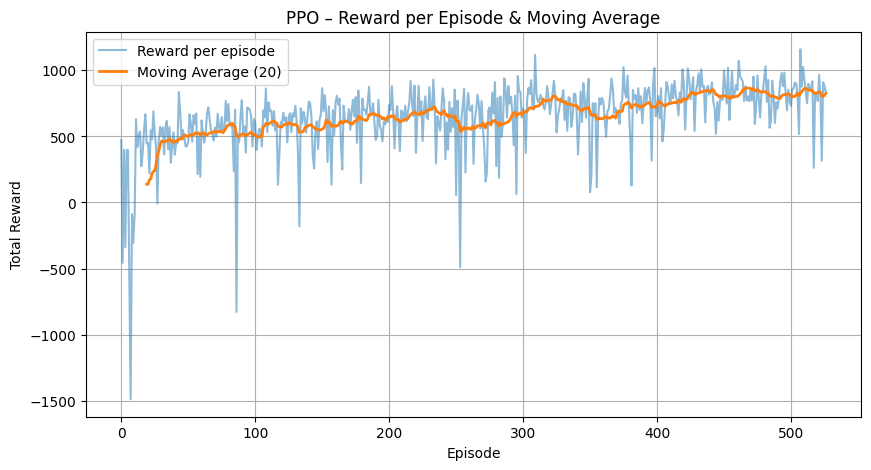

In [26]:
plt.figure(figsize=(10,5))
rewards = reward_logger_ppo.episode_rewards
window = 20
ma = pd.Series(rewards).rolling(window).mean()
plt.plot(rewards, alpha=0.5, label="Reward per episode")
plt.plot(ma, linewidth=2, label=f"Moving Average ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("PPO – Reward per Episode & Moving Average")
plt.grid()
plt.show()


In [27]:
# Cell 7 : Save the trained model for future use
model_ppo.save("trained_ppo.zip")
print("Model saved!")


Model saved!


In [28]:
# Cell 8: Save the reward logger
import pickle
with open("rewards_logger_ppo.pkl", "wb") as f:
    pickle.dump(reward_logger_ppo.episode_rewards, f)
print("Episode rewards saved!")


Episode rewards saved!


In [29]:
# Cell 10: Load the trained agent (for evaluation)
from stable_baselines3 import PPO

model_ppo = PPO.load("trained_ppo.zip", env=env)
print("Loaded trained agent!")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded trained agent!


In [30]:
N_EVAL_EPISODES = 100

ppo_rewards = []
ppo_waiting_times = []
ppo_urgent_served = []
ppo_total_surgeries = []
ppo_overtime_cases = []

def get_base_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

for ep in range(N_EVAL_EPISODES):
    obs, info = env.reset()
    done = False
    total_reward = 0
    waiting_times = []
    urgent_served = 0
    total_surgeries = 0
    overtime_cases = 0

    base_env = get_base_env(env)
    already_scheduled = 0  # נוספו עד כה

    while not done:
        action, _ = model_ppo.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        base_env = get_base_env(env)
        # לולאה רק על מנותחים שהתווספו מאז הצעד האחרון
        new_scheduled = base_env.scheduled[already_scheduled:]
        for scheduled in new_scheduled:
            wt = scheduled['scheduled_time'] - scheduled['arrival_time']
            waiting_times.append(wt)
            if scheduled['urgency'] == 3:
                urgent_served += 1
            total_surgeries += 1
            end_time = scheduled['scheduled_time'] + scheduled['duration']
            if end_time > base_env.day_length:
                overtime_cases += 1
        already_scheduled += len(new_scheduled)

    ppo_rewards.append(total_reward)
    ppo_waiting_times.append(np.mean(waiting_times) if waiting_times else 0)
    ppo_urgent_served.append(urgent_served)
    ppo_total_surgeries.append(total_surgeries)
    ppo_overtime_cases.append(overtime_cases)

print(f"Agent (PPO) over {N_EVAL_EPISODES} episodes:")
print(f"Average total reward: {np.mean(ppo_rewards):.2f} ± {np.std(ppo_rewards):.2f}")
print(f"Average waiting time: {np.mean(ppo_waiting_times):.2f} ± {np.std(ppo_waiting_times):.2f} minutes")
print(f"Average urgent surgeries served: {np.mean(ppo_urgent_served):.2f} ± {np.std(ppo_urgent_served):.2f}")
print(f"Average total surgeries: {np.mean(ppo_total_surgeries):.2f} ± {np.std(ppo_total_surgeries):.2f}")
fraction_with_overtime = np.mean([o > 0 for o in ppo_overtime_cases])
print(f"Fraction of episodes with overtime surgeries: {fraction_with_overtime:.2%}")
print(f"Average overtime surgeries per episode: {np.mean(ppo_overtime_cases):.2f}")


Agent (PPO) over 100 episodes:
Average total reward: 850.63 ± 173.11
Average waiting time: 13.94 ± 6.44 minutes
Average urgent surgeries served: 7.41 ± 1.95
Average total surgeries: 18.00 ± 0.00
Fraction of episodes with overtime surgeries: 20.00%
Average overtime surgeries per episode: 0.29


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# A2C Grid search

```python
param_grid = {
    'learning_rate': [0.001, 0.0003],
    'n_steps': [5, 16],
    'gamma': [0.95, 0.99],
    'ent_coef': [0.0, 0.01],
    'net_arch': [[64, 64], [128, 128], [128, 256]],
}
combos = list(itertools.product(*param_grid.values()))
print(f"Total {len(combos)} grid search runs")

results = []

for idx, params in enumerate(combos):
    lr, n_steps, gamma, ent_coef, net_arch = params
    print(f"\n--- Grid Search {idx+1}/{len(combos)} ---")
    print(f"Params: lr={lr}, n_steps={n_steps}, gamma={gamma}, ent_coef={ent_coef}, net_arch={net_arch}")

    reward_logger_a2c = RewardLoggerCallback(check_freq=1000)
    model_a2c = A2C(
        "MlpPolicy",
        env,
        learning_rate=lr,
        n_steps=n_steps,
        gamma=gamma,
        ent_coef=ent_coef,
        policy_kwargs=dict(net_arch=net_arch),
        verbose=0,
    )
    model_a2c.learn(total_timesteps=48_000, callback=reward_logger_a2c)

    # הערכת ביצועים (10 אפיזודות)
    eval_rewards = []
    for ep in range(10):
        obs, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model_a2c.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    std_reward = np.std(eval_rewards)
    print(f"Mean Eval Reward: {avg_reward:.2f}, Std: {std_reward:.2f}")

    results.append({
        'learning_rate': lr,
        'n_steps': n_steps,
        'gamma': gamma,
        'ent_coef': ent_coef,
        'net_arch': str(net_arch),
        'avg_reward': avg_reward,
        'std_reward': std_reward
    })

df_results_A2C = pd.DataFrame(results)
df_results_A2C = df_results_A2C.sort_values('avg_reward', ascending=False).reset_index(drop=True)
df_results_A2C.round(2)

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# A2C Bayesian Optimization

```python
import optuna
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym

def optimize_a2c(trial):
    # טווחים לפרמטרים
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    n_steps = trial.suggest_int('n_steps', 5, 100)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.3, 1.0)
    
    model = A2C(
        "MlpPolicy",
        env,
        gamma=gamma,
        learning_rate=learning_rate,
        n_steps=n_steps,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm,
        verbose=0,
    )

    model.learn(total_timesteps=48000)  # 100 אפיזודות לערך

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10, return_episode_rewards=False)

    env.close()
    return mean_reward


study = optuna.create_study(direction="maximize")
study.optimize(optimize_a2c, n_trials=30)

print("Best A2C hyperparameters:")
print(study.best_params)


##### Best A2C hyperparameters: {'gamma': 0.9712712936970976, 'learning_rate': 0.0005302355245543153, 'n_steps': 20, 'ent_coef': 0.00018094963033287215, 'vf_coef': 0.7278345568849391, 'max_grad_norm': 0.4251566807025091}

<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# A2C (Default)

In [32]:
from stable_baselines3 import A2C

a2c_test = A2C("MlpPolicy", env, verbose=0)
a2c_test.learn(total_timesteps=48_000)

reward_logger_a2c_test = RewardLoggerCallback(check_freq=1000)
a2c_test.learn(total_timesteps=240_000, callback=reward_logger_a2c_test)


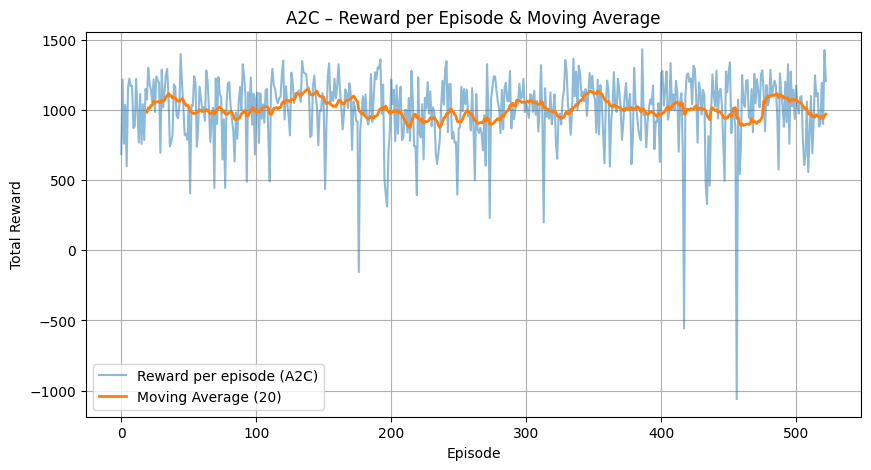

In [33]:
rewards_a2c_test = reward_logger_a2c_test.episode_rewards
window = 20
ma_a2c_test = pd.Series(rewards_a2c_test).rolling(window).mean()

plt.figure(figsize=(10,5))
plt.plot(rewards_a2c_test, alpha=0.5, label="Reward per episode (A2C)")
plt.plot(ma_a2c_test, linewidth=2, label=f"Moving Average ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C – Reward per Episode & Moving Average")
plt.legend()
plt.grid()
plt.show()


In [34]:
N_EVAL_EPISODES = 100

a2c_rewards = []
a2c_waiting_times = []
a2c_urgent_served = []
a2c_total_surgeries = []
a2c_overtime_cases = []

def get_base_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

for ep in range(N_EVAL_EPISODES):
    obs, info = env.reset()
    done = False
    total_reward = 0
    waiting_times = []
    urgent_served = 0
    total_surgeries = 0
    overtime_cases = 0

    base_env = get_base_env(env)
    already_scheduled = 0  # נוספו עד כה

    while not done:
        action, _ = a2c_test.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        base_env = get_base_env(env)
        # לולאה רק על מנותחים שהתווספו מאז הצעד האחרון
        new_scheduled = base_env.scheduled[already_scheduled:]
        for scheduled in new_scheduled:
            wt = scheduled['scheduled_time'] - scheduled['arrival_time']
            waiting_times.append(wt)
            if scheduled['urgency'] == 3:
                urgent_served += 1
            total_surgeries += 1
            end_time = scheduled['scheduled_time'] + scheduled['duration']
            if end_time > base_env.day_length:
                overtime_cases += 1
        already_scheduled += len(new_scheduled)

    a2c_rewards.append(total_reward)
    a2c_waiting_times.append(np.mean(waiting_times) if waiting_times else 0)
    a2c_urgent_served.append(urgent_served)
    a2c_total_surgeries.append(total_surgeries)
    a2c_overtime_cases.append(overtime_cases)

print(f"Agent (A2C) over {N_EVAL_EPISODES} episodes:")
print(f"Average total reward: {np.mean(a2c_rewards):.2f} ± {np.std(a2c_rewards):.2f}")
print(f"Average waiting time: {np.mean(a2c_waiting_times):.2f} ± {np.std(a2c_waiting_times):.2f} minutes")
print(f"Average urgent surgeries served: {np.mean(a2c_urgent_served):.2f} ± {np.std(a2c_urgent_served):.2f}")
print(f"Average total surgeries: {np.mean(a2c_total_surgeries):.2f} ± {np.std(a2c_total_surgeries):.2f}")
fraction_with_overtime = np.mean([o > 0 for o in a2c_overtime_cases])
print(f"Fraction of episodes with overtime surgeries: {fraction_with_overtime:.2%}")
print(f"Average overtime surgeries per episode: {np.mean(a2c_overtime_cases):.2f}")


Agent (A2C) over 100 episodes:
Average total reward: 1047.58 ± 232.67
Average waiting time: 11.79 ± 8.32 minutes
Average urgent surgeries served: 7.11 ± 1.95
Average total surgeries: 17.96 ± 0.20
Fraction of episodes with overtime surgeries: 12.00%
Average overtime surgeries per episode: 0.17


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# A2C (Tuned)

In [39]:
from stable_baselines3 import A2C

reward_logger_a2c = RewardLoggerCallback(check_freq=1000)

model_a2c = A2C(
    "MlpPolicy",
    env,
    learning_rate=0.00053,
    n_steps=5,  # ברירת מחדל, אפשר לשנות לפי צורך
    gamma=0.971,
    ent_coef = 0.00018,  # רגולריזציה למדיניות (מעט)
    vf_coef= 0.727,  # משקל גבוה לפונקציית ערך
    max_grad_norm = 0.425,  # קונטרול על גודל גרדיאנט

    policy_kwargs=dict(net_arch=[128, 128]),
    verbose=1,
)
model_a2c.learn(total_timesteps=240_000, callback=reward_logger_a2c)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 480      |
|    ep_rew_mean        | 168      |
| time/                 |          |
|    fps                | 534      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -3.17    |
|    explained_variance | -0.0701  |
|    learning_rate      | 0.00053  |
|    n_updates          | 99       |
|    policy_loss        | -7.8     |
|    value_loss         | 8.05     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 480      |
|    ep_rew_mean        | 271      |
| time/                 |          |
|    fps                | 549      |
|    iterations         | 200      |
|    time_elapsed 

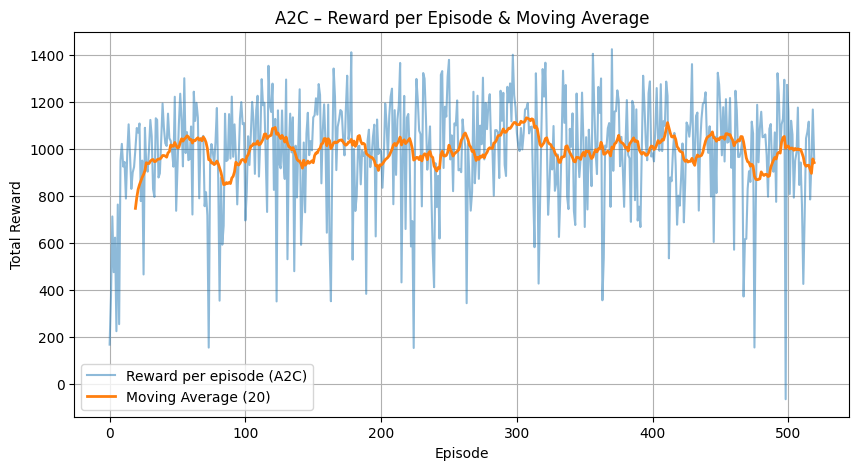

In [40]:
rewards_a2c = reward_logger_a2c.episode_rewards
window = 20
ma_a2c = pd.Series(rewards_a2c).rolling(window).mean()

plt.figure(figsize=(10,5))
plt.plot(rewards_a2c, alpha=0.5, label="Reward per episode (A2C)")
plt.plot(ma_a2c, linewidth=2, label=f"Moving Average ({window})")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C – Reward per Episode & Moving Average")
plt.legend()
plt.grid()
plt.show()


In [42]:
# Cell 7 : Save the trained model for future use
model_a2c.save("trained_a2c.zip")
print("Model saved!")


Model saved!


In [44]:
# Cell 8: Save the reward logger
import pickle
with open("rewards_logger_a2c.pkl", "wb") as f:
    pickle.dump(reward_logger_a2c.episode_rewards, f)
print("Episode rewards saved!")


Episode rewards saved!


In [45]:
# Cell 10: Load the trained agent (for evaluation)
from stable_baselines3 import A2C

model_a2c = A2C.load("trained_a2c.zip", env=env)
print("Loaded trained agent!")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Loaded trained agent!


In [46]:
N_EVAL_EPISODES = 100

a2c_rewards = []
a2c_waiting_times = []
a2c_urgent_served = []
a2c_total_surgeries = []
a2c_overtime_cases = []

def get_base_env(env):
    while hasattr(env, 'env'):
        env = env.env
    return env

for ep in range(N_EVAL_EPISODES):
    obs, info = env.reset()
    done = False
    total_reward = 0
    waiting_times = []
    urgent_served = 0
    total_surgeries = 0
    overtime_cases = 0

    base_env = get_base_env(env)
    already_scheduled = 0  # נוספו עד כה

    while not done:
        action, _ = model_a2c.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_reward += reward
        base_env = get_base_env(env)
        # לולאה רק על מנותחים שהתווספו מאז הצעד האחרון
        new_scheduled = base_env.scheduled[already_scheduled:]
        for scheduled in new_scheduled:
            wt = scheduled['scheduled_time'] - scheduled['arrival_time']
            waiting_times.append(wt)
            if scheduled['urgency'] == 3:
                urgent_served += 1
            total_surgeries += 1
            end_time = scheduled['scheduled_time'] + scheduled['duration']
            if end_time > base_env.day_length:
                overtime_cases += 1
        already_scheduled += len(new_scheduled)

    a2c_rewards.append(total_reward)
    a2c_waiting_times.append(np.mean(waiting_times) if waiting_times else 0)
    a2c_urgent_served.append(urgent_served)
    a2c_total_surgeries.append(total_surgeries)
    a2c_overtime_cases.append(overtime_cases)

print(f"Agent (A2C) over {N_EVAL_EPISODES} episodes:")
print(f"Average total reward: {np.mean(a2c_rewards):.2f} ± {np.std(a2c_rewards):.2f}")
print(f"Average waiting time: {np.mean(a2c_waiting_times):.2f} ± {np.std(a2c_waiting_times):.2f} minutes")
print(f"Average urgent surgeries served: {np.mean(a2c_urgent_served):.2f} ± {np.std(a2c_urgent_served):.2f}")
print(f"Average total surgeries: {np.mean(a2c_total_surgeries):.2f} ± {np.std(a2c_total_surgeries):.2f}")
fraction_with_overtime = np.mean([o > 0 for o in a2c_overtime_cases])
print(f"Fraction of episodes with overtime surgeries: {fraction_with_overtime:.2%}")
print(f"Average overtime surgeries per episode: {np.mean(a2c_overtime_cases):.2f}")


Agent (A2C) over 100 episodes:
Average total reward: 948.62 ± 192.55
Average waiting time: 18.21 ± 6.68 minutes
Average urgent surgeries served: 6.79 ± 2.21
Average total surgeries: 17.97 ± 0.30
Fraction of episodes with overtime surgeries: 43.00%
Average overtime surgeries per episode: 0.65


In [48]:
summary = pd.DataFrame({
    'Model': ['DQN', 'PPO', 'A2C'],
    'Average Reward': [np.mean(agent_rewards), np.mean(ppo_rewards), np.mean(a2c_rewards)],
    'Std Reward': [np.std(agent_rewards), np.std(ppo_rewards), np.std(a2c_rewards)],
    'Median Reward': [np.median(agent_rewards), np.median(ppo_rewards), np.median(a2c_rewards)],
    'Min Rewוard': [np.min(agent_rewards), np.min(ppo_rewards), np.min(a2c_rewards)],
    'Max Reward': [np.max(agent_rewards), np.max(ppo_rewards), np.max(a2c_rewards)]
})
summary


,Model,Average Reward,Std Reward,Median Reward,Min Reward,Max Reward
0,DQN,1095.6060,618.761609,1180.000,-4764.05,1477.60
1,PPO,850.6345,173.110323,869.725,137.20,1225.55
2,A2C,948.6165,192.551991,972.950,155.35,1412.10


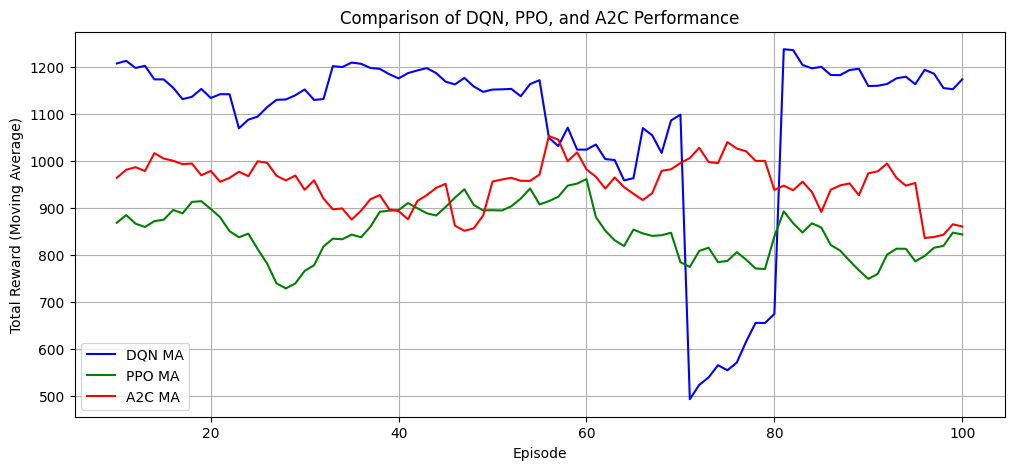

In [47]:
episodes = np.arange(1, N_EVAL_EPISODES+1)
episodes_500 = np.arange(1, 500+1)
window = 10
import seaborn as sns

plt.figure(figsize=(12,5))
sns.lineplot(x=episodes, y=pd.Series(agent_rewards).rolling(window).mean(), label="DQN MA", color='blue')
sns.lineplot(x=episodes, y=pd.Series(ppo_rewards).rolling(window).mean(), label="PPO MA", color='green')
sns.lineplot(x=episodes, y=pd.Series(a2c_rewards).rolling(window).mean(), label="A2C MA", color='red')
plt.xlabel("Episode")
plt.ylabel("Total Reward (Moving Average)")
plt.title("Comparison of DQN, PPO, and A2C Performance")
plt.legend()
plt.grid()
plt.show()


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">
    
# Non-Learning Baselines: Random & Heuristic

In [52]:
# הכנת רשימת ניתוחים קבועה/אקראית
surgeries = generate_surgeries(num_surgeries=15)
env = OperatingRoomEnv(num_rooms=3, surgeries=surgeries)

num_episodes = 500
episode_rewards = []

# === סוכן רנדומלי ===
random_rewards = []
for ep in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
    random_rewards.append(total_reward)
    #print(f"Episode {ep+1}: Total Reward = {total_reward}")

# === סוכן חמדן (Heuristic) ===
heuristic_rewards = []

for ep in range(num_episodes):
    obs, _ = env.reset(random_patients=True)
    done = False
    total_reward = 0
    while not done:
        # נבחר פעולה שמייצגת ניתוח הכי דחוף מחכה, אם קיים
        waiting = obs['waiting_times']
        urgencies = obs['urgencies']

        if obs['num_waiting'] > 0:
            # בחר את האינדקס של החולה הכי דחוף שממתין (urgency גבוהה)
            candidate_idx = np.argmax(urgencies)
            action = candidate_idx  # נניח שפעולה היא לפי אינדקס ממתין
        else:
            action = env.action_space.sample()  # fallback

        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
    heuristic_rewards.append(total_reward)


In [53]:
baseline_summary = pd.DataFrame({
    'Method': ['Random Policy', 'Heuristic Policy'],
    'Average Reward': [np.mean(random_rewards), np.mean(heuristic_rewards)],
    'Std Reward': [np.std(random_rewards), np.std(heuristic_rewards)],
    'Min Reward': [np.min(random_rewards), np.min(heuristic_rewards)],
    'Max Reward': [np.max(random_rewards), np.max(heuristic_rewards)],
})

baseline_summary


,Method,Average Reward,Std Reward,Min Reward,Max Reward
0,Random Policy,160.5431,164.678337,-743.0,437.7
1,Heuristic Policy,-1759.1457,1540.890733,-16789.0,-257.3


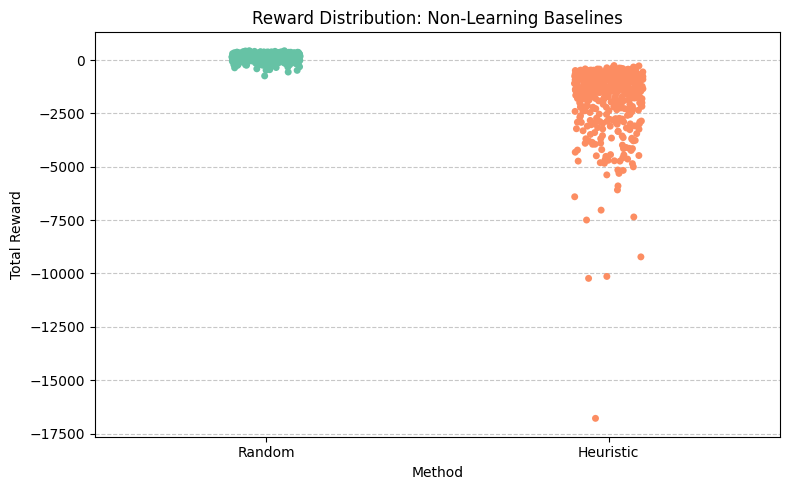

In [57]:
# Combine for plotting
df_baseline = pd.DataFrame({
    'Reward': random_rewards + heuristic_rewards,
    'Method': ['Random'] * len(random_rewards) + ['Heuristic'] * len(heuristic_rewards)
})

plt.figure(figsize=(8, 5))
sns.stripplot(data=df_baseline, x='Method', y='Reward', hue = 'Method',palette='Set2')
plt.title("Reward Distribution: Non-Learning Baselines")
plt.ylabel("Total Reward")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## ⚖️ Baseline Comparison: Random vs. Heuristic (Non-Learning Agents)

To benchmark the learning-based agents (DQN, PPO, A2C), we evaluated two simple baseline strategies:

- 🎲 **Random Policy**: selects a legal action uniformly at random.
- 🧠 **Heuristic Policy**: selects the most urgent waiting patient (if any) at each step.

Both baselines were tested over 500 randomized episodes in the same environment.

---

### 📊 Results Summary

| Method           | Avg. Reward | Std. Dev   | Min Reward | Max Reward |
|------------------|-------------|------------|------------|------------|
| Random Policy     | **160.54**  | 164.68     | -743.00    | 437.70     |
| Heuristic Policy  | -1759.15    | **1540.89**| **-16789.00** | -257.30    |

---

### 🔍 Key Insights

- ✅ The **Random Policy** surprisingly achieved **positive average reward**, and showed reasonable consistency.
- ❌ The **Heuristic Policy** underperformed drastically, with frequent catastrophic penalties and very low maximum reward.
- These results validate the need for **learned policies**, which can better manage long-term scheduling constraints.

> Even a naïve random approach outperforms a rigid, greedy heuristic in this complex environment.



<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## 🧠 Final Comparison: Model Performance Summary & Conclusions

Throughout this project, we explored and optimized the performance of three RL agents — `DQN`, `PPO`, and `A2C` — in a custom surgical scheduling environment.

---

### 🔧 Methodology Overview

For each model, we followed a consistent process:

1. **Baseline Evaluation**  
   - Train each model using default parameters on a fixed surgery list (100 episodes × 4 seeds).  
   - Evaluate stability and average performance to identify strong candidates for tuning.

2. **Hyperparameter Optimization**
   - Select the two most promising models based on default performance.
   - Use **Grid Search** for DQN and PPO.
   - Use **Bayesian Optimization** (Optuna) for A2C due to poor default performance and larger search space.

3. **Post-Tuning Evaluation**
   - Retrain each tuned model for 500 episodes and evaluate on 100 randomized test episodes.
   - Record performance metrics across clinical and operational dimensions.

---

### 📌 Why Bayesian Optimization for A2C?

A2C showed highly inconsistent results under default settings, unlike PPO and DQN.  
Its sensitivity to hyperparameters and on-policy nature made it a good candidate for **Bayesian Optimization**, which:

- Prioritizes exploration of promising parameter regions.
- Efficiently searches complex hyperparameter spaces.
- Adaptively adjusts based on prior results — ideal for unstable models like A2C.

---

### 📊 Final Comparison Table (Post-Tuning Evaluation on 100 Episodes)

| Metric                                | DQN                | PPO               | A2C (Default)       | A2C (Tuned)          |
|--------------------------------------|--------------------|-------------------|---------------------|----------------------|
| **Avg. total reward**                | **1095.61 ± 618.76** | 850.63 ± 173.11  | 1047.58 ± 232.67    | 948.62 ± 192.55      |
| **Avg. waiting time (min)**          | **8.27 ± 5.13**     | 13.94 ± 6.44     | 11.79 ± 8.32         | 18.21 ± 6.68         |
| **Urgent surgeries served**          | 7.13 ± 2.07         | **7.41 ± 1.95**  | 7.11 ± 1.95          | **6.79 ± 2.21**      |
| **Total surgeries per episode**      | 17.94 ± 0.34        | **18.00 ± 0.00** | **17.96 ± 0.20**     | 17.97 ± 0.30         |
| **Episodes with overtime (%)**       | **8.00%**           | 20.00%           | 12.00%               | 43.00%               |
| **Overtime surgeries per episode**   | **0.12**            | 0.29             | 0.17                 | 0.65                 |

---

### 🧭 Interpretation & Decision Factors

- ✅ **DQN** achieved the highest average reward, shortest patient wait times, and lowest overtime usage.  
  However, it also showed **the highest variance**, indicating inconsistency across episodes.

- ✅ **A2C (Default)** provided **more stable and reliable performance**, with moderate rewards and low variance.  
  It may be more suitable in **risk-sensitive applications** where consistency is prioritized.

---

### 🏆 Conclusion

> The final recommendation depends on the deployment context:  
> - Choose **DQN** if **maximum efficiency** is desired and **variance is acceptable**.  
> - Choose **A2C (Default)** if **stability and robustness** are critical, even at the cost of peak performance.

> Both models demonstrate practical viability and offer a strong foundation for future research and real-world testing.

</div>


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## 📈 Visual Comparison: Training vs. Evaluation

In [49]:
import pickle

# קריאת תוצאות מכל קובץ pkl
with open("rewards_dqn.pkl", "rb") as f:
    dqn_rewards_log = pickle.load(f)

with open("rewards_ppo.pkl", "rb") as f:
    ppo_rewards_log = pickle.load(f)

with open("rewards_logger_a2c.pkl", "rb") as f:
    a2c_rewards_log = pickle.load(f)


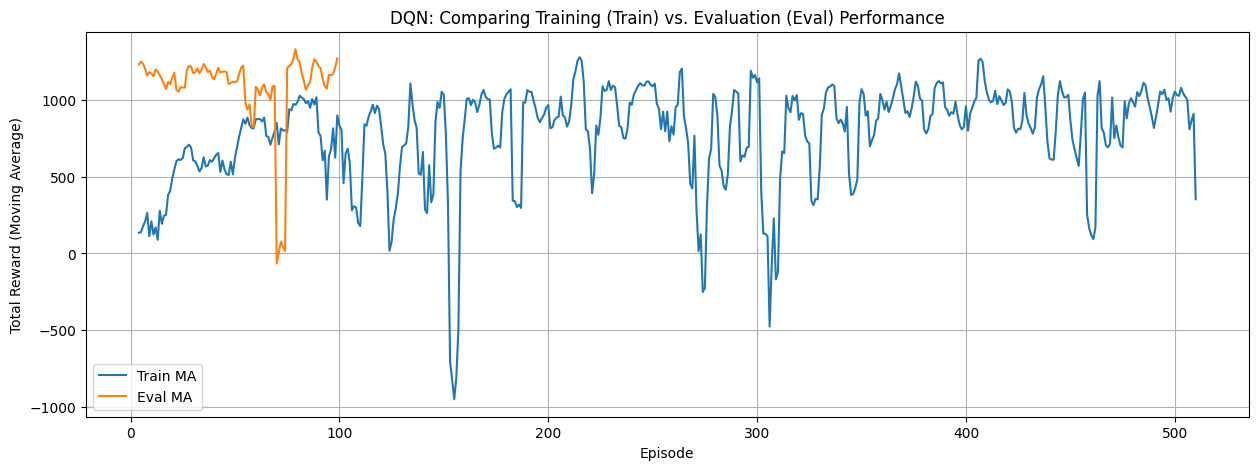

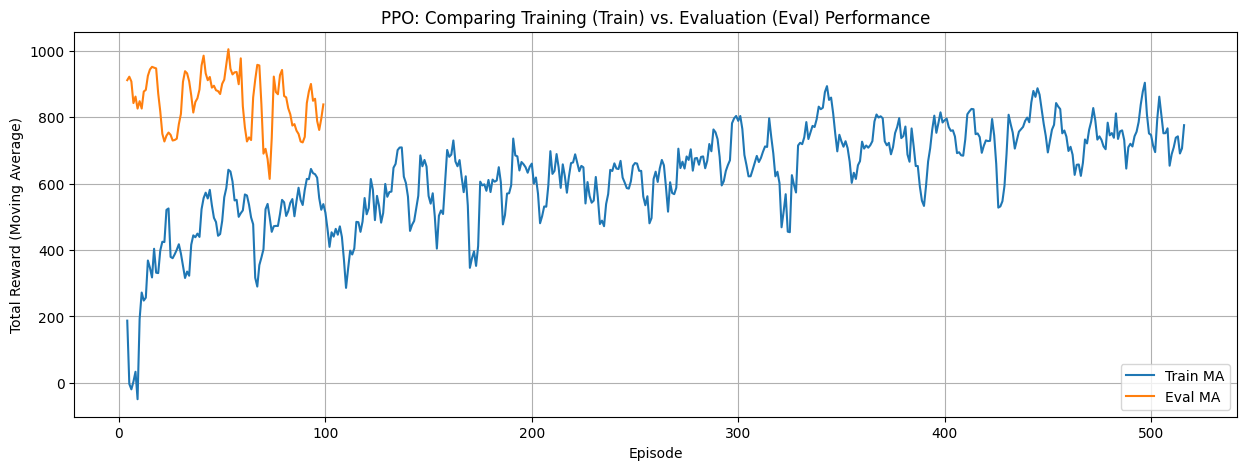

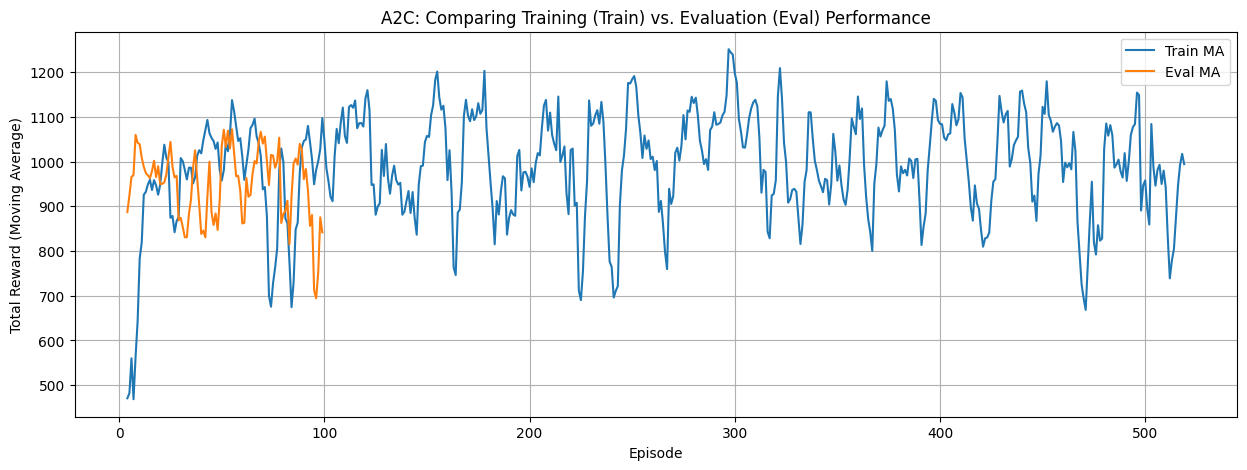

In [50]:
import matplotlib.pyplot as plt

def plot_train_vs_eval(train_rewards, eval_rewards, model_name, window=5):
    import pandas as pd
    ma_train = pd.Series(train_rewards).rolling(window).mean()
    ma_eval = pd.Series(eval_rewards).rolling(window).mean()
    plt.figure(figsize=(15,5))
    plt.plot(ma_train, label='Train MA')
    plt.plot(ma_eval, label='Eval MA')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward (Moving Average)")
    plt.title(f"{model_name}: Comparing Training (Train) vs. Evaluation (Eval) Performance")
    plt.legend()
    plt.grid()
    plt.show()
    
##### if you loading the pickle files - run without ".episode_rewards"

plot_train_vs_eval(dqn_rewards_log, agent_rewards , "DQN") 
plot_train_vs_eval(ppo_rewards_log, ppo_rewards, "PPO")
plot_train_vs_eval(a2c_rewards_log, a2c_rewards, "A2C")


In [51]:
import numpy as np
import pandas as pd

summary = pd.DataFrame({
    'Model': ['DQN', 'PPO', 'A2C'],
    'Train Avg Reward': [
        np.mean(reward_logger.episode_rewards),
        np.mean(reward_logger_ppo.episode_rewards),
        np.mean(reward_logger_a2c.episode_rewards)
    ],
    'Eval Avg Reward': [
        np.mean(agent_rewards),        # DQN
        np.mean(ppo_rewards),          # PPO
        np.mean(a2c_rewards)           # A2C
    ],
    'Train Std Reward': [
        np.std(reward_logger.episode_rewards),
        np.std(reward_logger_ppo.episode_rewards),
        np.std(reward_logger_a2c.episode_rewards)
    ],
    'Eval Std Reward': [
        np.std(agent_rewards),
        np.std(ppo_rewards),
        np.std(a2c_rewards)
    ],
    'Train Median Reward': [
        np.median(reward_logger.episode_rewards),
        np.median(reward_logger_ppo.episode_rewards),
        np.median(reward_logger_a2c.episode_rewards)        
    ],
    'Eval Median Reward': [
        np.std(agent_rewards),
        np.std(ppo_rewards),
        np.std(a2c_rewards)
    ]
    
})
summary


,Model,Train Avg Reward,Eval Avg Reward,Train Std Reward,Eval Std Reward,Train Median Reward,Eval Median Reward
0,DQN,843.584229,1095.6060,560.259644,618.761609,987.549988,618.761609
1,PPO,653.058960,850.6345,252.541885,173.110323,695.350037,173.110323
2,A2C,987.557983,948.6165,228.450928,192.551991,1021.525024,192.551991


<div style="border: 2px solid #8ad3f1; border-radius: 10px; padding: 15px; background-color: #f0f8ff;">

## 📈 Visual Comparison: Training vs. Evaluation

To further validate our conclusions, we compared each model’s **training reward progression** to its **evaluation performance** on held-out randomized episodes.  
These plots visualize each agent’s ability to generalize beyond its training environment.

---

### 🧪 Observations by Model:

#### 🟦 DQN
- Achieved high peak rewards during both training and evaluation.
- Exhibited **spikes and dips** in training, suggesting sensitivity to random seeds or batch effects.
- **Evaluation is strong and stable**, confirming high generalization capacity.

#### 🟧 PPO
- Demonstrated a **steady training curve**, improving gradually.
- Evaluation curve remained mostly below training, suggesting **moderate generalization**.
- Balanced but less aggressive than DQN.

#### 🟩 A2C (Default)
- Training converged fast with high rewards.
- **Evaluation closely tracks training**, indicating **very stable and predictable behavior**.
- The smoothest generalization among all models.

---

### 🧠 Summary Insight

> All three agents demonstrate reasonable learning behavior.  
> - **DQN** performs best in reward terms but exhibits volatility.  
> - **A2C** is the **most consistent and stable** — both in training and evaluation.  
> - **PPO** offers a good compromise, though with moderate performance.

These trends reinforce our earlier conclusion:  
- **DQN** is suitable when performance is paramount.  
- **A2C** is preferred where **reliability and repeatability** are critical.



## 🎬 Agent Simulation: Watch A2C Agent in Action

Below is a visual simulation of the trained A2C agent operating in a realistic surgical scheduling scenario.

- The environment runs for up to 480 minutes (a full workday).
- Each frame shows:
  - Active surgeries per room
  - Queue of waiting patients with urgency and waiting time
  - Time progression

The video highlights how the agent makes dynamic decisions under resource constraints.

> The agent used here was loaded from `trained_a2c.zip`.

▶️ Press play below to watch the simulation.


In [9]:
# Cell 10: Load the trained agent (for evaluation)
from stable_baselines3 import A2C

model_a2c = A2C.load("trained_a2c.zip", env=env)
print("✅ Loaded trained A2C agent!")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Loaded trained A2C agent!


In [10]:
import matplotlib.patches as patches

def plot_env(base_env, obs_dict, step, save_path):
    fig, ax = plt.subplots(figsize=(16, 7.04))
    ax.set_xlim(0, 1200)
    ax.set_ylim(0, 600)
    ax.axis('off')

    # ציור חדרי ניתוח
    for i, room_time in enumerate(obs_dict['rooms']):
        x = 120 + i*310
        y = 80
        rect_color = '#87CEEB' if room_time == 0 else '#9C27B0'
        rect = patches.FancyBboxPatch((x, y), 180, 110, boxstyle="round,pad=0.1", linewidth=3, facecolor=rect_color)
        ax.add_patch(rect)
        ax.text(x+90, y-20, f"Room {i+1}", ha='center', fontsize=16, color='black', fontweight='bold')
        pat = None
        for p in base_env.scheduled:
            # נזהה פציינט ששוכב עכשיו בחדר
            if p['room']==i and p['scheduled_time'] <= obs_dict['time'] < (p['scheduled_time']+p['duration']):
                pat = p
                break
        if room_time > 0 and pat:
            color = 'red' if pat['urgency'] == 3 else 'royalblue'
            circ = plt.Circle((x+90, y+60), 32, color=color)
            ax.add_patch(circ)
            # אין ids – מציגים רק "Patient"
            ax.text(x+90, y+60, "Patient", ha='center', va='center', fontsize=16, color='white')
            # מציגים זמן שנותר ומשך המתנה (אם זמין)
            time_left = pat['duration'] - (obs_dict['time'] - pat['scheduled_time'])
            ax.text(x+90, y+110, f"Time left: {max(time_left, 0)}", ha='center', fontsize=13, color='black')
            wait = pat.get('waited', pat['scheduled_time'] - pat['arrival_time'])
            ax.text(x+90, y+142, f"Wait: {wait}", ha='center', fontsize=13, color='black')
        elif room_time == 0:
            ax.text(x+90, y+60, "Free", ha='center', va='center', fontsize=18, color='green')

    # ציור תור ממתינים (ללא ids)
    for i in range(base_env.max_patients_in_obs):
        cx = 90 + i*120
        cy = 340
        rect = patches.FancyBboxPatch((cx-32, cy+30), 64, 15, boxstyle="round,pad=0.1", linewidth=2, facecolor='#BDBDBD')
        ax.add_patch(rect)
        if i < obs_dict['num_waiting']:
            urgency = obs_dict['urgencies'][i]
            color = 'red' if urgency == 3 else 'royalblue'
            circ = plt.Circle((cx, cy), 28, color=color)
            ax.add_patch(circ)
            # נציג את מספר המטופל בתור (מתחיל מ־1)
            ax.text(cx, cy, f"{i+1}", ha='center', va='center', fontsize=18, color='white')
            duration = obs_dict['waiting_times'][i] if 'waiting_times' in obs_dict else ''
            ax.text(cx, cy+38, f"Wait: {obs_dict['waiting_times'][i]}", ha='center', fontsize=13)
            # אין מידע על אורך הניתוח, אפשר להוריד/להסתיר את זה

    # מציגים רק את הזמן!
    ax.text(1100, 570, f"Time: {obs_dict['time']}", ha='center', fontsize=18, color='black')
    plt.savefig(save_path, bbox_inches=None, pad_inches=0, dpi=100)
    plt.close()


In [11]:
import os, shutil
if os.path.exists('frames'): shutil.rmtree('frames')
os.makedirs('frames', exist_ok=True)

obs, _ = env.reset()
done = False
step = 0

while not done and step < 480:
    # קבל את הסביבה הבסיסית (ה-unwrapped) לקבלת obs כ-dict לציור
    base_env = env
    while hasattr(base_env, 'env'):
        base_env = base_env.env
    obs_dict = base_env._get_obs()
    plot_env(base_env, obs_dict, step, f"frames/frame_{step:03d}.png")
    action, _ = model_a2c.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    step += 1

In [12]:
import imageio.v2 as imageio
from IPython.display import Video

with imageio.get_writer('simulation_agent.mp4', fps=5) as writer:
    for i in range(step):
        filename = f"frames/frame_{i:03d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

Video("simulation_agent.mp4", embed=True, width=850, height=400)